In [1]:
import pandas as pd

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [6]:
url= "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
df= pd.read_csv(url)

In [7]:
## filter out top 4 largest cities
df = df.sort_values('SizeRank').head(4)

In [8]:
id_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName']

melted = pd.melt(df, id_vars=id_cols, value_name="Typical Home Value", var_name='Month')
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Month,Typical Home Value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [9]:
melted['Month']= pd.to_datetime(melted['Month'])
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   RegionID            1092 non-null   int64         
 1   SizeRank            1092 non-null   int64         
 2   RegionName          1092 non-null   object        
 3   RegionType          1092 non-null   object        
 4   StateName           1092 non-null   object        
 5   State               1092 non-null   object        
 6   Metro               1092 non-null   object        
 7   CountyName          1092 non-null   object        
 8   Month               1092 non-null   datetime64[ns]
 9   Typical Home Value  1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 85.4+ KB


In [10]:
melted= melted.set_index('Month')
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Typical Home Value
Month,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...,...,...,...
2022-08-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [11]:
df_ts = melted.groupby("RegionName").resample("M").asfreq("M")
df_ts

RegionID  SizeRank RegionName RegionType StateName  \
RegionName Month                                                            
Chicago    2000-01-31     17426         3    Chicago       city        IL   
           2000-02-29     17426         3    Chicago       city        IL   
           2000-03-31     17426         3    Chicago       city        IL   
           2000-04-30     17426         3    Chicago       city        IL   
           2000-05-31     17426         3    Chicago       city        IL   
...                         ...       ...        ...        ...       ...   
New York   2022-05-31      6181         0   New York       city        NY   
           2022-06-30      6181         0   New York       city        NY   
           2022-07-31      6181         0   New York       city        NY   
           2022-08-31      6181         0   New York       city        NY   
           2022-09-30      6181         0   New York       city        NY   

                      State                                  Metro  \
RegionName Month                                                     
Chicago    2000-01-31    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-02-29    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-03-31    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-04-30    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-05-31    IL     Chicago-Naperville-Elgin, IL-IN-WI   
...                     ...                                    ...   
New York   2022-05-31    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-06-30    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-07-31    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-08-31    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-09-30    NY  New York-Newark-Jersey City, NY-NJ-PA   

                          CountyName  Typical Home Value  
RegionName Month                                          
Chicago    2000-01-31    Cook County            166139.0  
           2000-02-29    Cook County            166536.0  
           2000-03-31    Cook County            167368.0  
           2000-04-30    Cook County            168826.0  
           2000-05-31    Cook County            170499.0  
...                              ...                 ...  
New York   2022-05-31  Queens County            768797.0  
           2022-06-30  Queens County            773944.0  
           2022-07-31  Queens County            777692.0  
           2022-08-31  Queens County            779960.0  
           2022-09-30  Queens County            781622.0  

[1092 rows x 9 columns]

In [12]:
import matplotlib.ticker as mticks

def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [13]:
unstacked = df_ts.unstack(level=0)["Typical Home Value"]
unstacked

RegionName,Chicago,Houston,Los Angeles,New York
Month,,,,
2000-01-31,166139.0,109068.0,234181.0,253690.0
2000-02-29,166536.0,109079.0,234401.0,255517.0
2000-03-31,167368.0,108878.0,235513.0,257207.0
2000-04-30,168826.0,108881.0,237589.0,260310.0
2000-05-31,170499.0,108834.0,240113.0,263204.0
...,...,...,...,...
2022-05-31,312487.0,265558.0,990391.0,768797.0
2022-06-30,314663.0,268901.0,992337.0,773944.0
2022-07-31,315910.0,271059.0,992630.0,777692.0


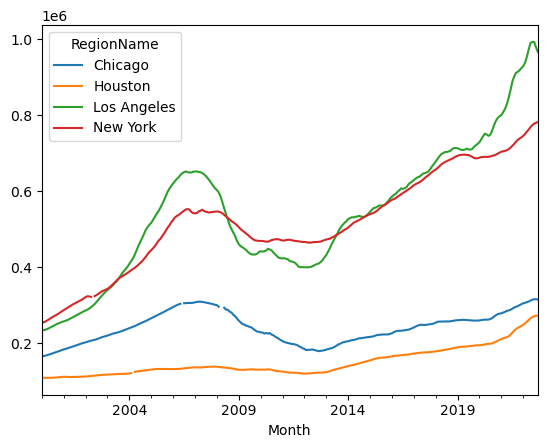

In [14]:
ax= unstacked.plot()

In [15]:
# GRIDSEARCH

ny = unstacked['New York']

ny = ny.loc['2018':]
ny

Month
2018-01-31    656700.0
2018-02-28    661012.0
2018-03-31    665672.0
2018-04-30    669989.0
2018-05-31    673514.0
2018-06-30    676434.0
2018-07-31    678984.0
2018-08-31    681140.0
2018-09-30    683546.0
2018-10-31    685588.0
2018-11-30    688553.0
2018-12-31    691226.0
2019-01-31    693208.0
2019-02-28    694425.0
2019-03-31    695720.0
2019-04-30    695824.0
2019-05-31    696173.0
2019-06-30    695186.0
2019-07-31    695010.0
2019-08-31    692926.0
2019-09-30    690189.0
2019-10-31    687693.0
2019-11-30    686304.0
2019-12-31    686650.0
2020-01-31    688073.0
2020-02-29    689697.0
2020-03-31    690055.0
2020-04-30    690520.0
2020-05-31    689921.0
2020-06-30    690785.0
2020-07-31    691384.0
2020-08-31    693097.0
2020-09-30    694261.0
2020-10-31    696260.0
2020-11-30    698929.0
2020-12-31    701899.0
2021-01-31    703956.0
2021-02-28    705003.0
2021-03-31    706066.0
2021-04-30    707633.0
2021-05-31    710706.0
2021-06-30    714507.0
2021-07-31    719155.0
2021-

In [16]:
ny.isna().sum()

0

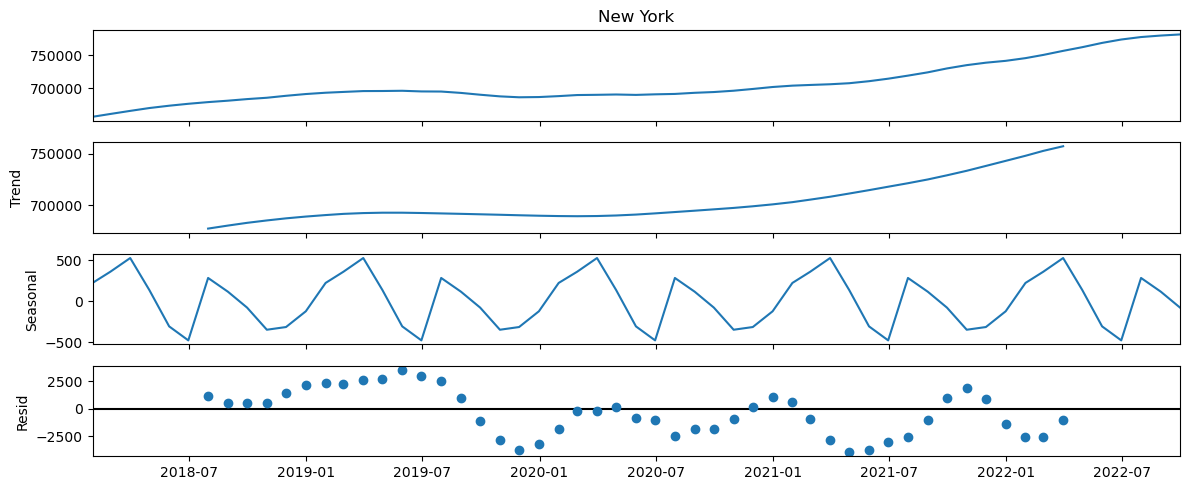

In [17]:
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

decomp = tsa.seasonal_decompose(ny)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [18]:
ndiffs(ny)

2

<Axes: xlabel='Month'>

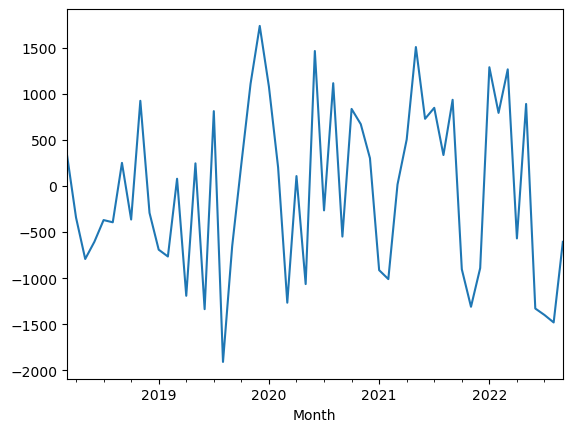

In [19]:
ny_diff= ny.diff().diff().dropna()
ny_diff.plot()

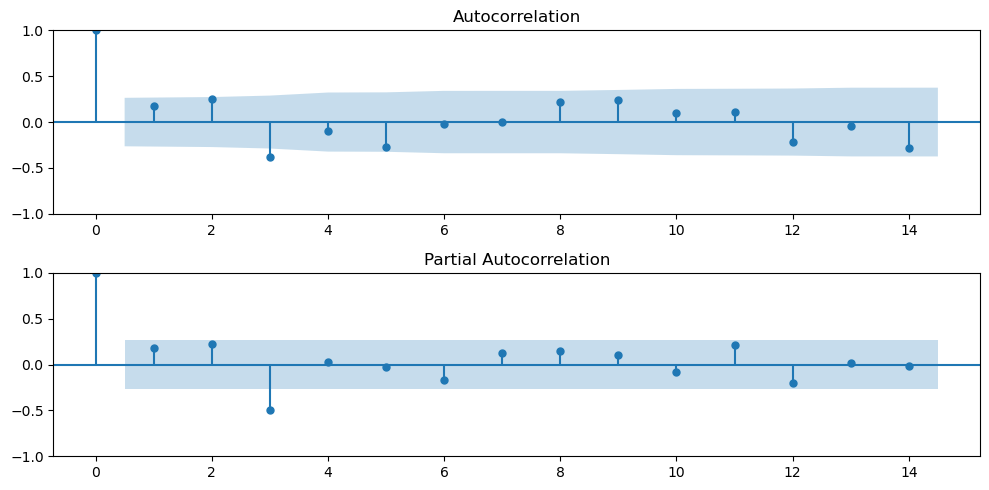

In [20]:
plot_acf_pacf(ny_diff, nlags=14);

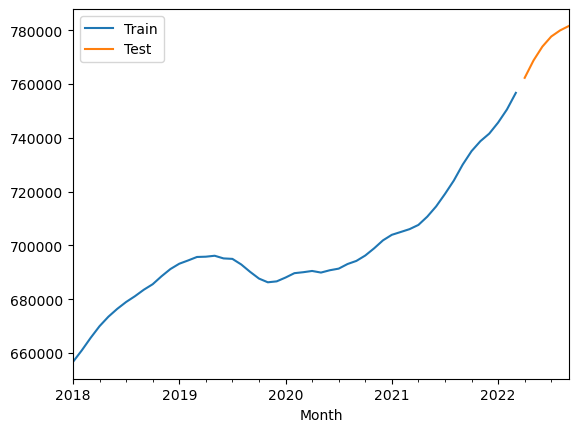

In [21]:
train, test = train_test_split(ny, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [24]:
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary

q = 1  # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,334.764
- MSE = 119,049,473.658
- RMSE = 10,910.980
- R^2 = -1.639
- MAPE = 1.33%


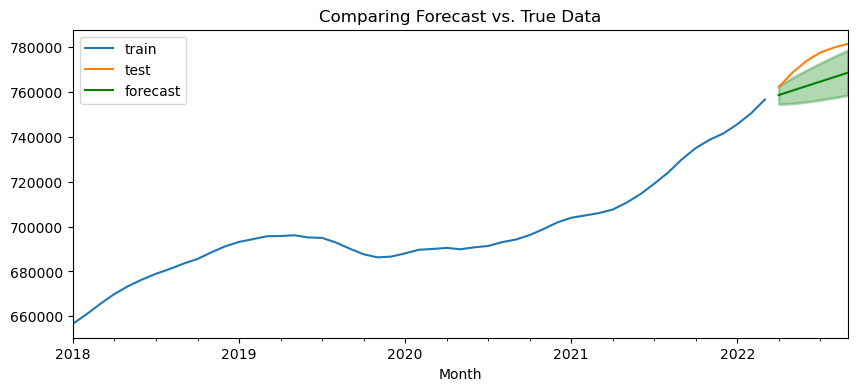

In [25]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [23]:
# What is the predicted home value in New York City 6 months into the future (beyond the dataset)?
## The price of homes is predicted to be the current value multiplied by 1.0133.

# What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?
## 1.33%